**ML.AI Hackathon 2025 - Cancer Type Classification Project**

**Private Score : 0.983**

**Public Score : 0.991**

In [27]:
import pandas as pd
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [28]:
train_labeled = train.merge(train_labels, on='Id')
X_labeled = train_labeled.drop(columns=['Id', 'Class_x', 'Class_y'])
y_labeled = train_labeled['Class_y']

In [29]:
train_unlabeled = train[~train['Id'].isin(train_labels['Id'])].copy()
X_unlabeled = train_unlabeled.drop(columns=['Id', 'Class'])
X_test = test.drop(columns=['Id'])

**Exploratory Data Analysis**

C:\Users\DELL\AppData\Local\Temp\ipykernel_24168\2089131352.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labeled, palette='coolwarm')


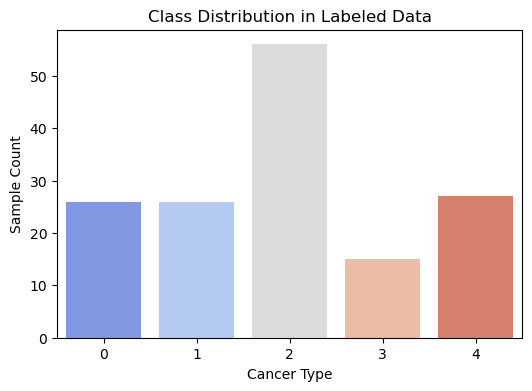

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(6,4))
sns.countplot(x=y_labeled, palette='coolwarm')
plt.title("Class Distribution in Labeled Data")
plt.xlabel("Cancer Type")
plt.ylabel("Sample Count")
plt.show()

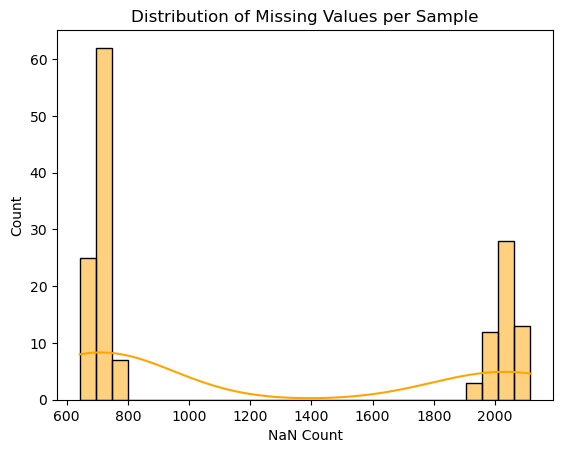

In [31]:
# Visualize missing values per sample
nan_counts = X_labeled.copy()
nan_counts['NaN Count'] = nan_counts.isna().sum(axis=1)
sns.histplot(nan_counts['NaN Count'], bins=28, kde=True, color='orange')
plt.title("Distribution of Missing Values per Sample")
plt.show()

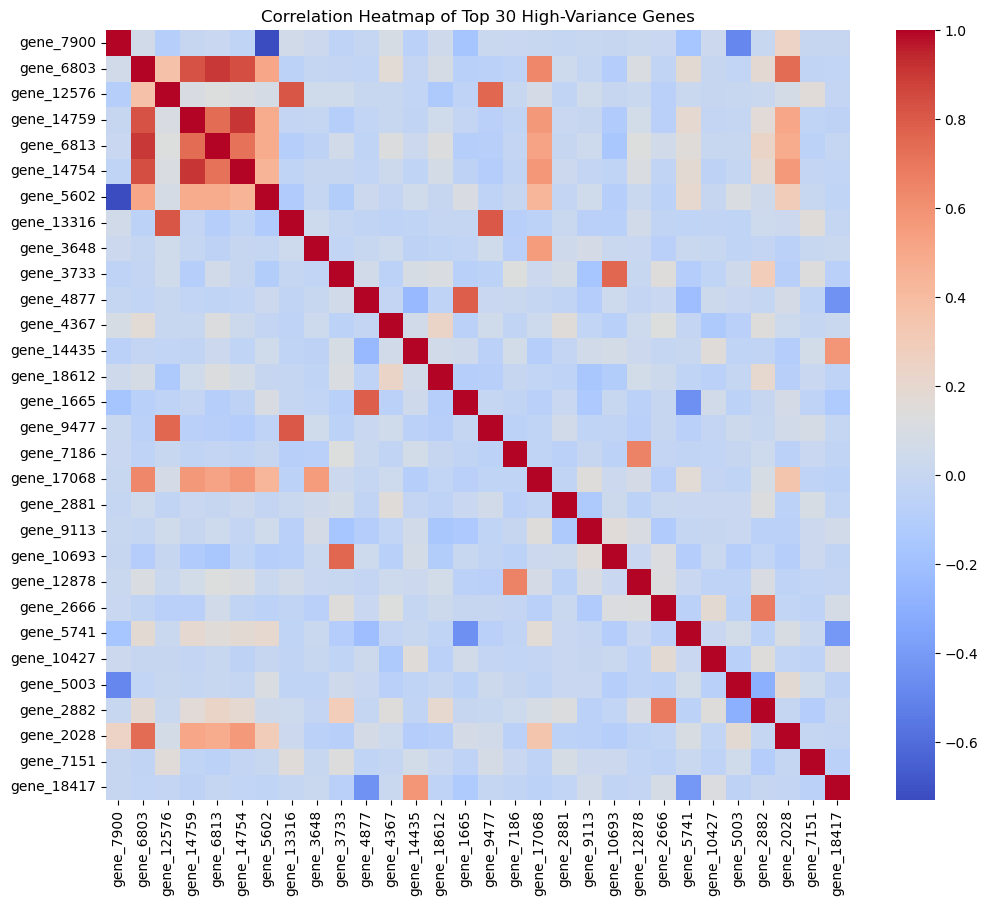

In [32]:
# Correlation Heatmap (for top 30 genes by variance)
X_corr_df = X_labeled.copy()
X_corr_df = pd.DataFrame(X_corr_df)
X_corr_df['Class'] = y_labeled.values
var_top = X_corr_df.drop('Class', axis=1).var().sort_values(ascending=False).head(30).index
corr_matrix = X_corr_df[var_top].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Top 30 High-Variance Genes")
plt.show()

**Imputation and Scaling**

In [33]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

imputer = KNNImputer(n_neighbors=3)
X_labeled = imputer.fit_transform(X_labeled)
X_unlabeled = imputer.transform(X_unlabeled)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_labeled = scaler.fit_transform(X_labeled)
X_unlabeled = scaler.transform(X_unlabeled)
X_test = scaler.transform(X_test)

**Experimenting with EDA**

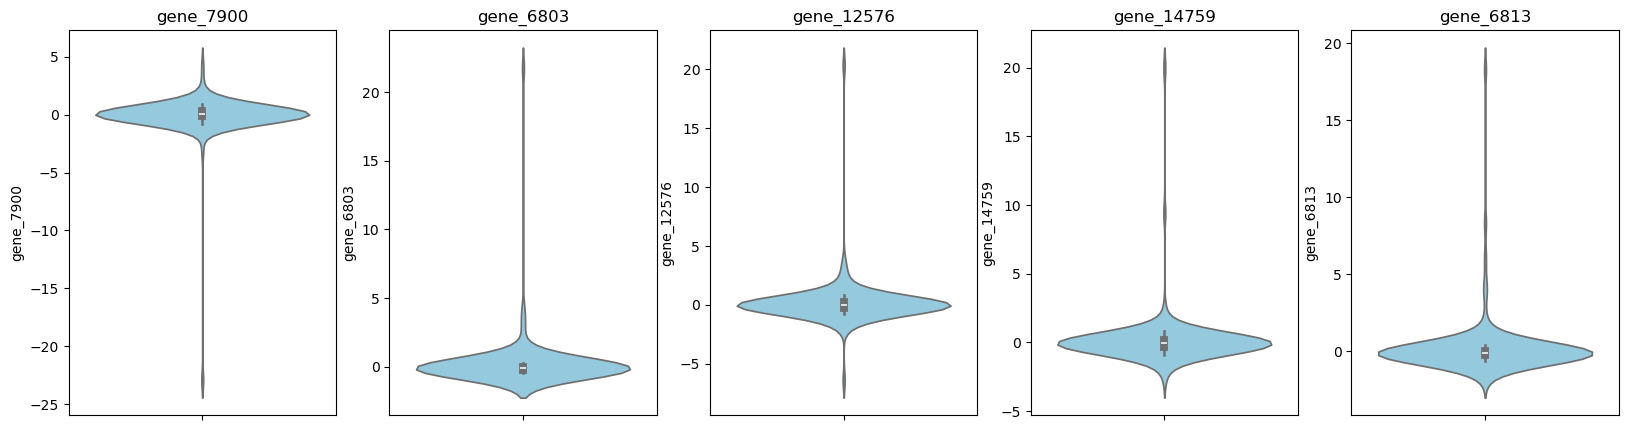

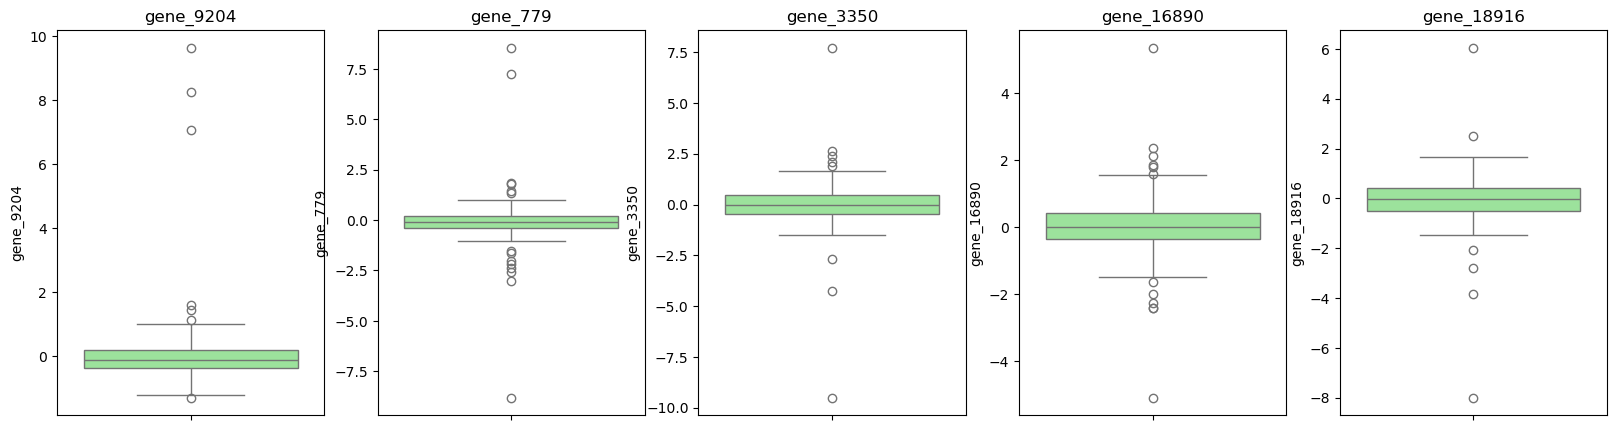

In [34]:
# Use the correct column names for X_labeled DataFrame
X_labeled_df = train_labeled.drop(columns=['Id', 'Class_x', 'Class_y'])

var_series = X_labeled_df.var(axis=0)
high_var_features = var_series.sort_values(ascending=False).head(5).index
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, idx in enumerate(high_var_features):
    sns.violinplot(y=X_labeled_df[idx], ax=axes[i], color='skyblue')
    axes[i].set_title(f"{idx}")

outlier_genes = ['gene_9204', 'gene_779', 'gene_3350', 'gene_16890', 'gene_18916']
outlier_df = X_labeled_df  # Already has correct columns
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, gene in enumerate(outlier_genes):
    sns.boxplot(y=outlier_df[gene], ax=axes[i], color='lightgreen')
    axes[i].set_title(gene)

    
#not much useful info :(

**Feature Engineering**

In [35]:
top2 = high_var_features[:2]
X_labeled = pd.DataFrame(X_labeled, columns=[f'gene_{i+1}' for i in range(X_labeled.shape[1])])
# Use .loc with column names
X_labeled['gene_prod'] = X_labeled.loc[:, top2[0]] * X_labeled.loc[:, top2[1]]
X_unlabeled = pd.DataFrame(X_unlabeled, columns=X_labeled.columns[:-1])
X_unlabeled['gene_prod'] = X_unlabeled.loc[:, top2[0]] * X_unlabeled.loc[:, top2[1]]
X_test = pd.DataFrame(X_test, columns=X_labeled.columns[:-1])
X_test['gene_prod'] = X_test.loc[:, top2[0]] * X_test.loc[:, top2[1]]

**PCA**

In [36]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

pca = PCA(n_components=150, random_state=28)
X_labeled_pca = pca.fit_transform(X_labeled)
X_unlabeled_pca = pca.transform(X_unlabeled)
X_test_pca = pca.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=100)
X_labeled = selector.fit_transform(X_labeled_pca, y_labeled)
X_unlabeled = selector.transform(X_unlabeled_pca)
X_test = selector.transform(X_test_pca)

**Pseudo-labeling**

In [37]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=28)
model.fit(X_labeled, y_labeled)
probs = model.predict_proba(X_unlabeled)
confident_idx = np.max(probs, axis=1) >= 0.95
X_pseudo = X_unlabeled[confident_idx]
y_pseudo = np.argmax(probs[confident_idx], axis=1)

X_combined = np.vstack([X_labeled, X_pseudo])
y_combined = np.hstack([y_labeled, y_pseudo])

d:\New2\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:17:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Hyperparameter Tuning**

In [38]:
%%capture
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lgb_grid = GridSearchCV(LGBMClassifier(random_state=28), {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}, scoring='f1_macro', cv=3)
lgb_grid.fit(X_combined, y_combined)

cat_grid = GridSearchCV(CatBoostClassifier(verbose=0, random_state=28), {
    'learning_rate': [0.05, 0.1],
    'iterations': [100, 200]
}, scoring='f1_macro', cv=3)
cat_grid.fit(X_combined, y_combined)

**Ensemble Model & Evaluation**

In [ ]:
%%capture
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

xgb_final = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=28)
lgb_final = lgb_grid.best_estimator_
cat_final = cat_grid.best_estimator_

ensemble = VotingClassifier(estimators=[
    ('xgb', xgb_final),
    ('lgb', lgb_final),
    ('cat', cat_final)
], voting='soft')
ensemble.fit(X_combined, y_combined)

train_preds = ensemble.predict(X_combined)
train_f1 = f1_score(y_combined, train_preds, average='macro')


In [42]:
print(f"Final Ensemble Training Macro F1 Score: {train_f1:.4f}")

Final Ensemble Training Macro F1 Score: 1.0000


**Confusion Matrix**

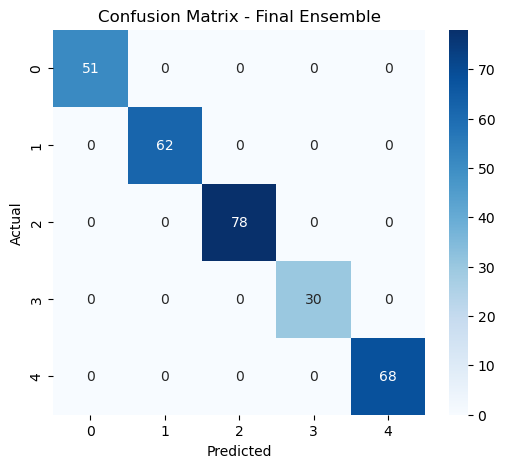

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_combined, train_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Ensemble")
plt.show()

In [44]:
#Classification report
print("\n Classification Report:")
print(classification_report(y_combined, train_preds))



 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        68

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



**Feature Importance**

d:\New2\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:21:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


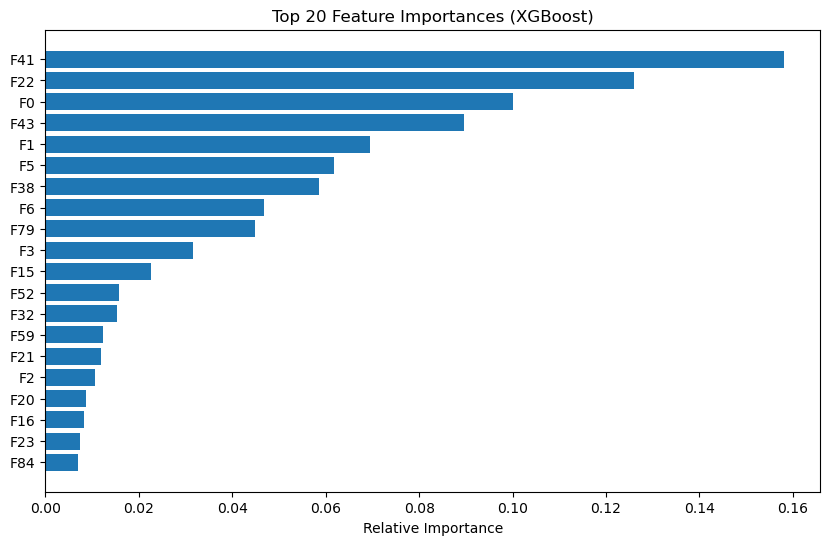

In [45]:
importances = xgb_final.fit(X_combined, y_combined).feature_importances_
indices = np.argsort(importances)[-20:]
plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f'F{i}' for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [46]:
preds = ensemble.predict(X_test)
submission['Class'] = preds
submission.to_csv('final_submission_final_11.csv', index=False)